In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
from matplotlib import rc
from matplotlib.tri import Triangulation
from sklearn.linear_model import LinearRegression
from scipy.signal import convolve2d as conv2

from scipy import ndimage

from skimage import measure

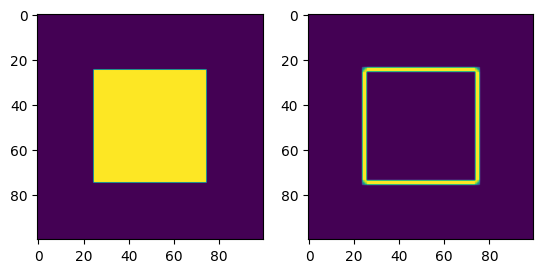

In [44]:
Test_array = np.zeros((100,100))
Test_array[25:75,25:75] = 1
D_array = np.array([[-1,0,1],[-1,0,1],[-1,0,1]])
GradT = np.sqrt(conv2(Test_array[:,:],D_array,'same','symm')**2 + conv2(Test_array[:,:],D_array.T,'same','symm')**2)/2 #1/2 for using the center derivative and 1/3 because for some reason it multiplies it by 3 (maybe the convolution adds up the number of terms for each row)

plt.subplot(121)
plt.imshow(Test_array)
plt.subplot(122)
plt.imshow(GradT) 



In [45]:
print(np.sum(Test_array))
print(np.sum(GradT))

2500.0
593.4295532842377


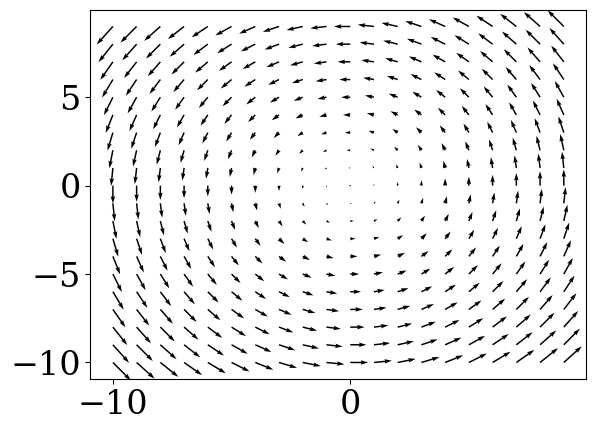

In [25]:
X = np.arange(-10, 10, 1)
Y = np.arange(-10, 10, 1)
U, V = np.meshgrid(X, Y)

fig, ax = plt.subplots()
q = ax.quiver(X, Y, -V, U)
ax.quiverkey(q, X=0.3, Y=1.1, U=10,
             label='Quiver key, length = 10', labelpos='E')

In [43]:
np.sum(GradT)**2/np.sum(Test_array)

15.651494876050219

# Cahn Hilliard Equation

We are going to implement the Cahn-Hilliard equation for the conservative dynamics of an order parameter $m$ that has spatial variations described below:

$$\partial_t m = \nabla^2(\frac{\delta \hat{f}}{\delta m})$$

For a simplified Ginzburg Landau free energy density of the form $\hat{f} = \frac{1}{2}(\nabla m)^2 + \frac{1}{2}(1-m^2)^2$

The Cahn-Hilliard equation is derived from the continuity equation:

$$\partial_t m + \nabla\cdot\mathbf{J} = 0$$

where $\mathbf{J} = -\nabla ( \frac{\delta\hat{f}}{\delta m})$ is a current.

Solving these expressions leads to the following equation:

$$\partial_t m = -2(\frac{1}{2}\Delta^2 m + (1-3 m^2)\Delta m - 6 m (\nabla m)^2) $$

Where $\Delta = \nabla^2$ is the Laplacian operator.

Numerically we can consider a field on a square grid $m_{i,j}[n]$

The gradient in the square grid can be approximated by a linear operator $\mathcal{D}$ defined as 

$$
\begin{bmatrix}
-1& 0 & 1\\
-1& 0 & 1\\
-1& 0 & 1\\
\end{bmatrix}$$

and

$$\nabla m \approx (\vec{\mathcal{D}} m)_{i,j} = [ (\mathcal{D} m)_{i,j} , (\mathcal{D}^T m)_{i,j}]$$ 
where $\mathcal{D}m$ is a convolution of $\mathcal{D}$ on $m$

The Laplacian can also be defined as a linear operator $\mathcal{L}$ defined as 

$$
\begin{bmatrix}
1/4& 1/2 & 1/4\\
1/2& -3 & 1/2\\
1/4& 1/2 & 1/4\\
\end{bmatrix}$$

Using the Euler method we can rewrite the expression above as:

$$m_{i,j}[n+1] = m_{i,j}[n] - 2 \Delta_t (\frac{1}{2} F3_{i,j} + (1 - 3 m^2_{i,j}[n])F2_{i,j}  - 6 m_{i,j}[n] F1_{i,j})\\
F1 = (\vec{\mathcal{D}} m)\circ(\vec{\mathcal{D}} m)[n]\\
F2 = (\mathcal{L} m[n])\\
F3 = \mathcal{L}(\mathcal{L} m[n])$$

where $\circ$ indicates a element-wise (Hadamard) product


Form is reminiscent of KPZ equation and also of Kuramoto-Sivashinski equation (if coefficients were constant)

The biharmonic equation is a fourth-order partial differential equation which arises in areas of continuum mechanics, including linear elasticity theory and the solution of Stokes flows. Specifically, it is used in the modeling of thin structures that react elastically to external forces. 

If m is harmonic, this simplifies to 
$$\partial_t m = -12 m (\nabla m)^2 $$

m is between $\pm 1$

In [13]:
L_array = np.array([[1/4,1/2,1/4],[1/2,-3,1/2],[1/4,1/2,1/4]])
D_array = np.array([[-1,0,1],[-1,0,1],[-1,0,1]])/6

Msize = 200
M_avg = 0
M_dev = 1.0
M_array = (2*(np.random.rand(Msize,Msize)>0.6)-1)*M_dev + M_avg 


In [17]:
#Initial conditions



Nsteps = 2000
dt = 0.0005

P_array = np.zeros((Msize,Msize,Nsteps))
P_array[:,:,0] = conv2(M_array,np.ones((2,2)),'same','wrap')

In [18]:
# Implementation

for i in range(Nsteps-1):
    GradP_j = 1/3*conv2(P_array[:,:,i],D_array,'same','symm')
    GradP_i = 1/3*conv2(P_array[:,:,i],D_array.T,'same','symm')
    LapP = conv2(P_array[:,:,i],L_array,'same','symm')
    Lap2P = conv2(LapP,L_array,'same','symm')
    DSqrdP = 1/2*(GradP_j**2 + GradP_i**2)
    
    P_array[:,:,i+1] = P_array[:,:,i] - 2*dt*(2*Lap2P + (1-3*P_array[:,:,i]**2)*LapP - 6*P_array[:,:,i]*DSqrdP)
    


In [11]:
font = font_manager.FontProperties(family='serif',
                                   style='normal', size=12)
font1 = {'family' : 'serif',
        'size'   : 24}
rc('font', **font1)

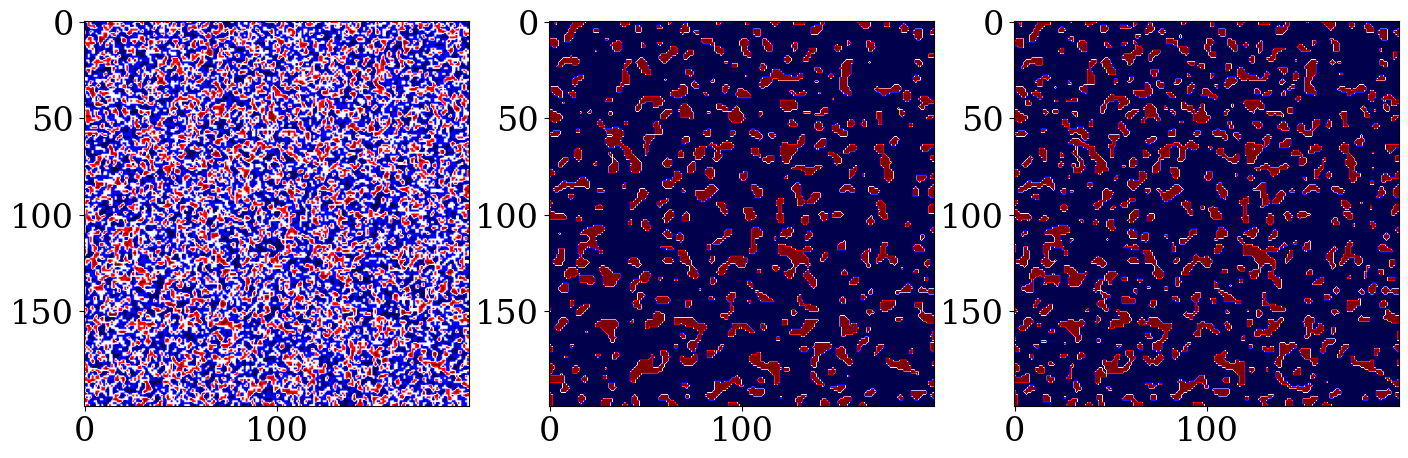

In [19]:
plt.figure(figsize=(17,5))
plt.subplot(131)
plt.imshow((P_array[:,:,0]),cmap='seismic')
plt.subplot(132)
plt.imshow((P_array[:,:,1000])>0,cmap='seismic')
plt.subplot(133)
plt.imshow((P_array[:,:,499])>0,cmap='seismic')


In [33]:
frame = 10
for i in range(0,Nsteps,frame):
    fig = plt.figure(figsize=(13,10))
    plt.pcolormesh(P_array[:,:,i],cmap='seismic')
    plt.colorbar()
    #plt.clim(9.5,10.5)
    
    plt.title("Cahn Hilliard - finite difference method",fontsize = 18,fontfamily= 'serif')
    plt.savefig('f'+str(int(i/frame))+'.png',dpi=150)
    plt.close(fig)
    

In [9]:
import movies_from_plots as mfp

In [34]:
img_array,size = mfp.loadframe(0,50,1,"f")
mfp.savevideo(img_array,"ch1.mp4",size,"f")

OpenCV: FFMPEG: tag 0x58564944/'DIVX' is not supported with codec id 12 and format 'mp4 / MP4 (MPEG-4 Part 14)'
OpenCV: FFMPEG: fallback to use tag 0x7634706d/'mp4v'


In [31]:
#Calculate width of surface


W = np.zeros(Nsteps)

for i in range(Nsteps):
    
    meanP = np.mean(P_array[:,:,i])
    W[i] = np.sqrt(np.mean((P_array[:,:,i]-meanP)**2))

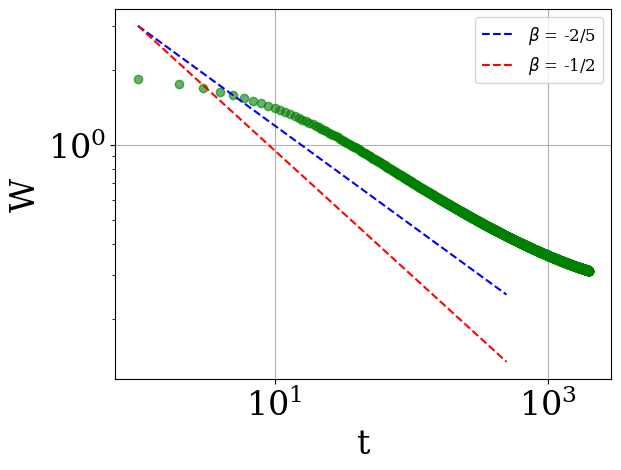

In [36]:
plt.plot(W,'go',alpha=0.6)
plt.plot(np.arange(1,500),3*np.arange(1,500)**(-2/5),'b--',label = "$\\beta$ = -2/5")
plt.plot(np.arange(1,500),3*np.arange(1,500)**(-0.5),'r--',label = "$\\beta$ = -1/2")
plt.yscale('log')
plt.xscale('log')
plt.xlabel("$\mathregular{t}$",fontsize = 24,fontdict= {'family':'serif'})
plt.ylabel("$\mathregular{W}$",fontsize = 24,fontdict= {'family':'serif'})
plt.legend(fontsize=13,prop=font,loc = "best")
plt.grid()

In [35]:
logW = np.log(W[10:500])
logX = np.log(np.arange(10,500))*(-1)
reg1 = LinearRegression().fit(logX.reshape(-1, 1),logW)
print('coef',reg1.coef_)
print('intercept', np.exp(reg1.intercept_))

coef [0.31863105]
intercept 3.078131642574696


In [121]:
def clustersizes(A):
    blobs = measure.label(A)
    maxB = np.max(blobs)
    list_L = np.zeros(maxB+1)
    for i in range(1,maxB+1):
       list_L[i] = np.sum(conv2(blobs==i,L_array)<0)
    return list_L

In [193]:
LargestC = np.zeros(Nsteps)
NC = np.zeros(Nsteps)

for i in range(Nsteps):
    
    meanP = np.mean(P_array[:,:,i])
    P1 = (P_array[:,:,i]-meanP)
    Pdev = P1<0
    dil_Pdev = (ndimage.binary_opening(Pdev))
    list_L = clustersizes(dil_Pdev)
    LargestC[i] = (np.max(list_L[1:]))
    NC[i] = len(list_L)

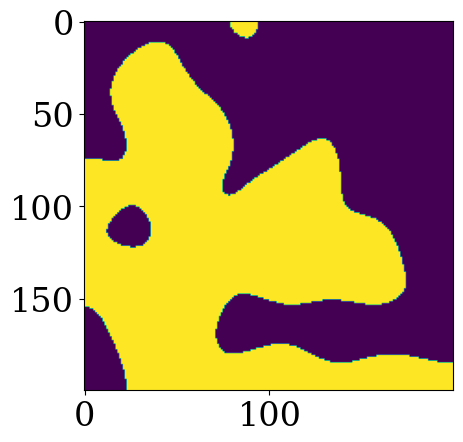

In [130]:
plt.imshow((P_array[:,:,-1]-meanP)>0)

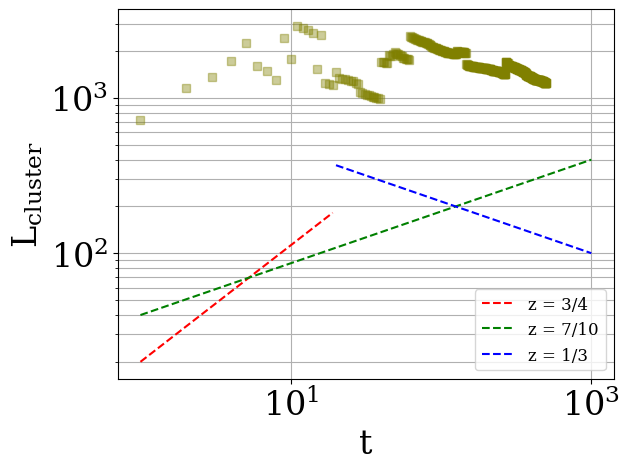

In [132]:
plt.plot(LargestC,'s',color = 'olive',alpha=0.4)
plt.yscale('log')
plt.xscale('log')
#plt.ylim(1000,10100)
plt.plot(np.arange(1,20),20*np.arange(1,20)**(3/4),'r--',label = "z = 3/4")
plt.plot(np.arange(1,1000),40*np.arange(1,1000)**(7/21),'g--',label = "z = 7/10")
plt.plot(np.arange(20,1000),1000*np.arange(20,1000)**(-1/3),'b--',label = "z = 1/3")
plt.xlabel("$\mathregular{t}$",fontsize = 24,fontdict= {'family':'serif'})
plt.ylabel("$\mathregular{L}_\mathregular{cluster}$",fontsize = 24,fontdict= {'family':'serif'})
plt.legend(fontsize=13,prop=font,loc = "best")
plt.grid(which="both")

In [100]:
logL = np.log(LargestC[1:20])
logX = np.log(np.arange(1,20))*(1)
reg3 = LinearRegression().fit(logX.reshape(-1, 1),logL)
print('coef',reg3.coef_)
print('intercept', np.exp(reg3.intercept_))

coef [0.8428473]
intercept 21.390656764604145


In [101]:
logL = np.log(LargestC[10:50])
logX = np.log(np.arange(10,50))
reg3 = LinearRegression().fit(logX.reshape(-1, 1),logL)
print('coef',reg3.coef_)
print('intercept', np.exp(reg3.intercept_))

coef [0.40421949]
intercept 71.2374707294073


In [102]:
logL = np.log(LargestC[20:500])
logX = np.log(np.arange(20,500))*(1/3)
reg3 = LinearRegression().fit(logX.reshape(-1, 1),logL)
print('coef',reg3.coef_)
print('intercept', np.exp(reg3.intercept_))

coef [-0.99365328]
intercept 1450.9227464247788


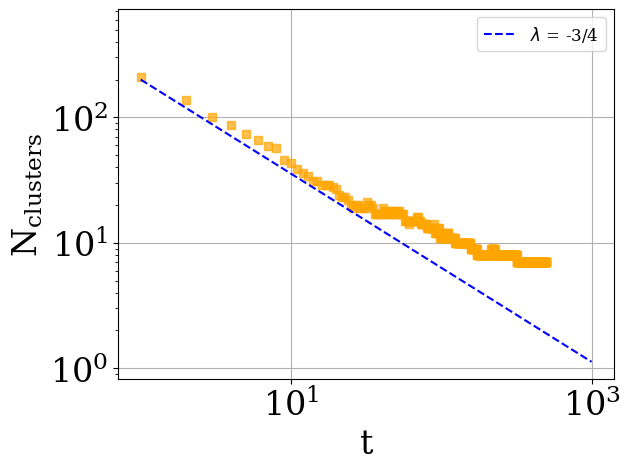

In [181]:
plt.plot(NC,'s',color='orange',alpha=0.7)
plt.yscale('log')
plt.xscale('log')
plt.plot(np.arange(1,1000),200*np.arange(1,1000)**(-0.75),'b--',label = "$\\lambda$ = -3/4")
plt.xlabel("$\mathregular{t}$",fontsize = 24,fontdict= {'family':'serif'})
plt.ylabel("$\mathregular{N}_\mathregular{clusters}$",fontsize = 24,fontdict= {'family':'serif'})
plt.legend(fontsize=13,prop=font,loc = "best")
plt.grid()

In [80]:
logN = np.log(NC[10:])
logX = np.log(np.arange(10,500))*(1)
reg4 = LinearRegression().fit(logX.reshape(-1, 1),logN)
print('coef',reg4.coef_.round(2))
print('intercept', np.exp(reg4.intercept_))

coef [-0.67]
intercept 147.47754657108928


In [194]:
with open("CahnHilliardExponentsFit.txt",'a') as text:
    text.write("\n")
    text.write("\n")
    logW = np.log(W[10:])
    logX = np.log(np.arange(10,500))*(1)
    reg4 = LinearRegression().fit(logX.reshape(-1, 1),logW)
    text.write("$\mathregular{\\beta=} $" + str(reg4.coef_.round(2)[0])+", $\mathregular{W_0} = $" + str(np.exp(reg4.intercept_).round(2))+"\n")
    logN = np.log(NC[10:])
    logX = np.log(np.arange(10,500))*(1)
    reg4 = LinearRegression().fit(logX.reshape(-1, 1),logN)
    text.write("$\mathregular{\\lamdba=} $" + str(reg4.coef_.round(2)[0])+", $\mathregular{N_0} = $" + str(np.exp(reg4.intercept_).round(2)))

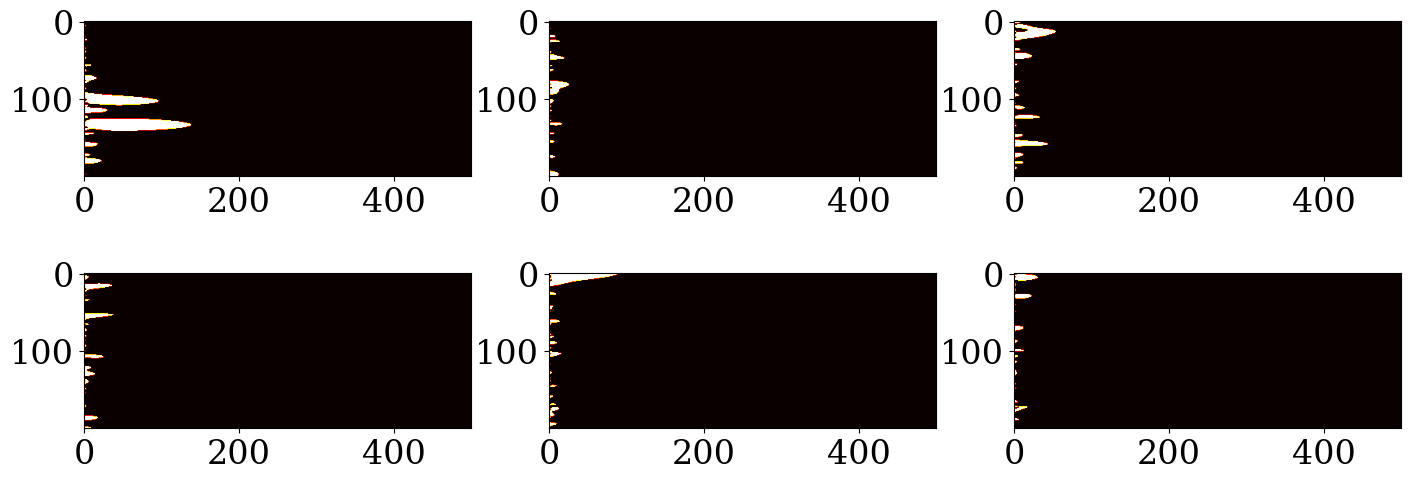

In [83]:
plt.figure(figsize=(17,6))
plt.subplot(231)
plt.imshow((P_array[0]>10.025),"hot")
plt.subplot(232)
plt.imshow((P_array[100]>10.025),"hot")
plt.subplot(233)
plt.imshow((P_array[-1]>10.025),"hot")
plt.subplot(234)
plt.imshow((P_array[:,0]>10.025),"hot")
plt.subplot(235)
plt.imshow((P_array[:,100]>10.025),"hot")
plt.subplot(236)
plt.imshow((P_array[:,-1]>10.025),"hot")
#plt.xscale('symlog')
#plt.clim(10,10.05)

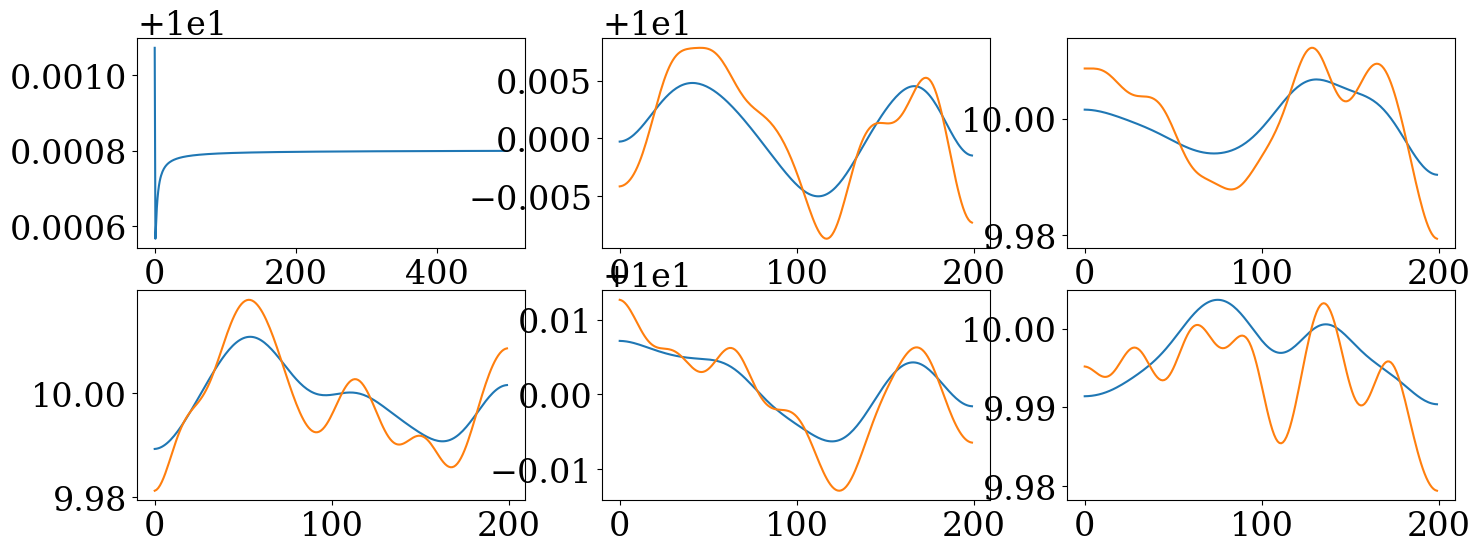

In [84]:
plt.figure(figsize=(17,6))
plt.subplot(231)
plt.plot(np.sum(np.sum(P_array[:,:,:],axis=0),axis=0)/(200*200))
#plt.plot((P_array[100,100,:]))
plt.subplot(232)
plt.plot((P_array[100,:,-1]))
plt.plot((P_array[100,:,-300]))
plt.subplot(233)
plt.plot((P_array[-1,:,-1]))
plt.plot((P_array[-1,:,-300]))
plt.subplot(234)
plt.plot((P_array[:,0,-1]))
plt.plot((P_array[:,0,-300]))
plt.subplot(235)
plt.plot((P_array[:,100,-1]))
plt.plot((P_array[:,100,-300]))
plt.subplot(236)
plt.plot((P_array[:,-1,-1]))
plt.plot((P_array[:,-1,-300]))

# Time Dependent Ginzburg Landau

We are going to implement the Time-Dependent Ginzburg equation for the conservative dynamics of an order parameter $m$ that has spatial variations described below:

$$\partial_t m = -\frac{\delta \hat{f}}{\delta m}$$

For a simplified Ginzburg Landau free energy density of the form $\hat{f} = \frac{1}{2}(\nabla m)^2 + \frac{1}{2}(1-m^2)^2$

This is below the critical point btw

Solving these expressions leads to the following equation:

$$\partial_t m = \nabla^2 m + 2 m-2m^3 $$

Numerically we can consider a field on a square grid $m_{i,j}[n]$

Using the Euler method we can rewrite the expression above as:

$$m_{i,j}[n+1] = m_{i,j}[n] +  \Delta_t (F2_{i,j} + 2 m_{i,j}(1 -  m^2_{i,j}[n]))\\

F = (\mathcal{L} m[n])$$

Form is reminiscent of a diffusion-reaction equation

n mathematics, mathematical physics and the theory of stochastic processes, a harmonic function is a twice continuously differentiable function $\displaystyle f:U\to \mathbb {R}$, where U is an open subset of $\mathbb {R} ^{n}$, that satisfies Laplace's equation.

If m is harmonic,

$$\partial_t m =  2 m (1-m^2) $$

In [254]:
L_array = np.array([[1/4,1/2,1/4],[1/2,-3,1/2],[1/4,1/2,1/4]])
D_array = np.array([[-1,0,1],[-1,0,1],[-1,0,1]])/6

Msize = 200
M_array = conv2(2*np.random.rand(Msize,Msize)-1,np.ones((2,2)),'same','wrap')

0.010000000000000002

In [255]:
# Implementation
dt = 0.01
alpha = 1
P1_array = np.zeros((Msize,Msize,Nsteps))
P1_array[:,:,0] = M_array*M_dev
for i in range(Nsteps-1):
    LapP = conv2(P1_array[:,:,i],L_array,'same','symm')    
    P1_array[:,:,i+1] = P1_array[:,:,i] + dt*(LapP + 2*alpha*P1_array[:,:,i]-2*P1_array[:,:,i]**3)

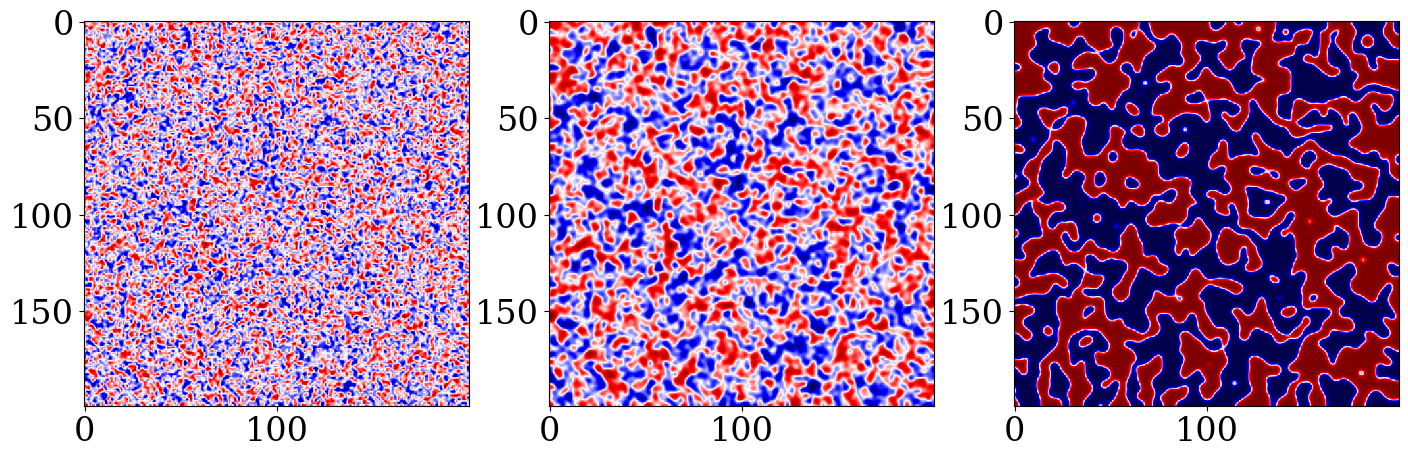

In [256]:
plt.figure(figsize=(17,5))
plt.subplot(131)
plt.imshow((P1_array[:,:,0]-np.mean(P1_array[:,:,0])),cmap='seismic')
plt.subplot(132)
plt.imshow((P1_array[:,:,100]-np.mean(P1_array[:,:,100])),cmap='seismic')
plt.subplot(133)
plt.imshow((P1_array[:,:,499]-np.mean(P1_array[:,:,499])),cmap='seismic')

In [257]:

W1 = np.zeros(Nsteps)

for i in range(Nsteps):
    
    meanP = np.mean(P1_array[:,:,i])
    W1[i] = np.sqrt(np.mean((P1_array[:,:,i]-meanP)**2))

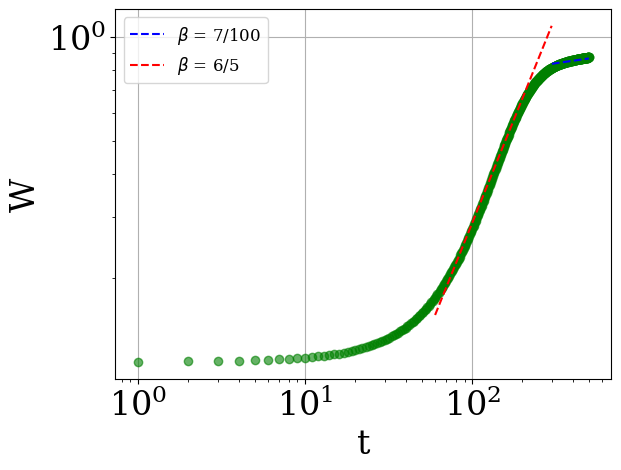

In [258]:
plt.plot(np.arange(0,500),W1[:500],'go',alpha=0.6)
plt.plot(np.arange(300,500),0.56*np.arange(300,500)**(7/100),'b--',label = "$\\beta$ = 7/100")
plt.plot(np.arange(60,300),0.00115*np.arange(60,300)**(6/5),'r--',label = "$\\beta$ = 6/5")
plt.yscale('log')
plt.xscale('log')
#plt.xlim(200,1000)
plt.xlabel("$\mathregular{t}$",fontsize = 24,fontdict= {'family':'serif'})
plt.ylabel("$\mathregular{W}$",fontsize = 24,fontdict= {'family':'serif'})
plt.legend(fontsize=13,prop=font,loc = "best")
plt.grid()

In [259]:
LargestC1 = np.zeros(Nsteps)
NC1 = np.zeros(Nsteps)

for i in range(Nsteps):
    
    meanP = np.mean(P1_array[:,:,i])
    P1 = (P1_array[:,:,i]-0)
    Pdev = P1>0.0
    dil_Pdev = (ndimage.binary_erosion(Pdev))
    list_L = clustersizes(dil_Pdev)
    LargestC1[i] = (np.max(list_L))
    NC1[i] = len(list_L)

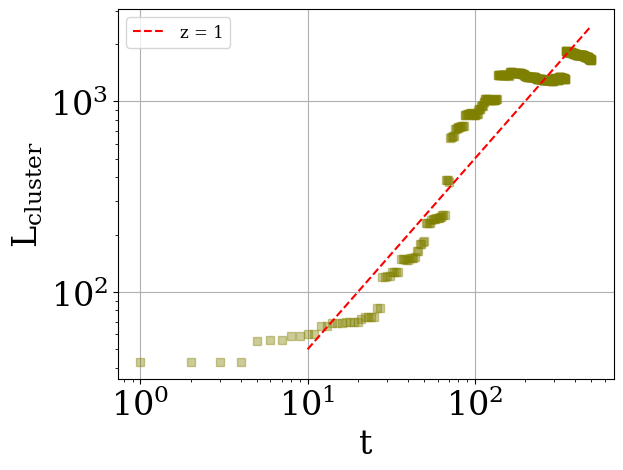

In [260]:
plt.plot(LargestC1,'s',color = 'olive',alpha=0.4)
plt.yscale('log')
plt.xscale('log')
#plt.ylim(100,1100)
plt.plot(np.arange(10,500),5*np.arange(10,500)**(1),'r--',label = "z = 1")
#plt.plot(np.arange(10,50),1450*np.arange(10,50)**(-3/10),'g--',label = "z = -3/10")
#plt.plot(np.arange(80,500),1620*np.arange(80,500)**(-20/100),'b--',label = "z = -1/5")
plt.xlabel("$\mathregular{t}$",fontsize = 24,fontdict= {'family':'serif'})
plt.ylabel("$\mathregular{L}_\mathregular{cluster}$",fontsize = 24,fontdict= {'family':'serif'})
plt.legend(fontsize=13,prop=font,loc = "best")
plt.grid()

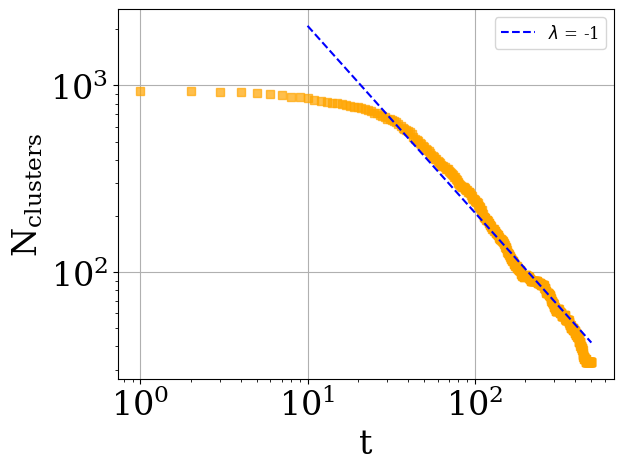

In [261]:
plt.plot(NC1,'s',color='orange',alpha=0.7)
plt.yscale('log')
plt.xscale('log')
plt.plot(np.arange(10,500),20880*np.arange(10,500)**(-1.0),'b--',label = "$\\lambda$ = -1")
plt.xlabel("$\mathregular{t}$",fontsize = 24,fontdict= {'family':'serif'})
plt.ylabel("$\mathregular{N}_\mathregular{clusters}$",fontsize = 24,fontdict= {'family':'serif'})
plt.legend(fontsize=13,prop=font,loc = "best")
plt.grid()

In [262]:
with open("GinzburgLandauExponentsFit.txt",'a') as text:
    logW = np.log(W1[30:300])
    logX = np.log(np.arange(30,300))*(1)
    reg4 = LinearRegression().fit(logX.reshape(-1, 1),logW)
    text.write("$\mathregular{\\beta=} $" + str(reg4.coef_.round(2)[0])+", $\mathregular{W_0} = $" + str(np.exp(reg4.intercept_).round(3))+"\n")
    logC = np.log(LargestC1[30:300])
    logX = np.log(np.arange(30,300))*(1)
    reg4 = LinearRegression().fit(logX.reshape(-1, 1),logC)
    text.write("$\mathregular{z=} $" + str(reg4.coef_.round(2)[0])+", $\mathregular{L_0} = $" + str(np.exp(reg4.intercept_).round(3))+"\n")
    logN = np.log(NC1[30:300])
    logX = np.log(np.arange(30,300))*(1)
    reg4 = LinearRegression().fit(logX.reshape(-1, 1),logN)
    text.write("$\mathregular{\\lamdba=} $" + str(reg4.coef_.round(2)[0])+", $\mathregular{N_0} = $" + str(np.exp(reg4.intercept_).round(3))+"\n")
    text.write("\n")

# Kardar-Parisi Zhang Equation

Not much changed, but what if we were to implement KPZ equation?

Solving these expressions leads to the following equation:

$$\partial_t m = \nu \Delta m + \frac{\lambda}{2}(\nabla m)^2 +\eta$$


Using the Euler method we can rewrite the expression above as:

$$m_{i,j}[n+1] = m_{i,j}[n] + \Delta_t ( \nu F2_{i,j}  + \frac{\lambda}{2} F1_{i,j}+\Eta)\\
F1 = (\vec{\mathcal{D}} m)\circ(\vec{\mathcal{D}} m)[n]\\
F2 = (\mathcal{L} m[n])$$

In [324]:
# Implementation

L_array = np.array([[1/4,1/2,1/4],[1/2,-3,1/2],[1/4,1/2,1/4]])
D_array = np.array([[-1,0,1],[-1,0,1],[-1,0,1]])/6

Msize = 200
M_array = conv2(2*np.random.rand(Msize,Msize)-1,np.ones((2,2)),'same','wrap')

dt = 0.01
alpha = 1
P2_array = np.zeros((Msize,Msize,Nsteps))
P2_array[:,:,0] = M_array*M_dev+M_avg


for i in range(Nsteps-1):
    Randt = 0.01*conv2(2*np.random.rand(Msize,Msize)-1,np.ones((2,2)),'same','wrap')
    GradP_j = conv2(P2_array[:,:,i],D_array,'same','symm')
    GradP_i = conv2(P2_array[:,:,i],D_array.T,'same','symm')
    LapP = conv2(P2_array[:,:,i],L_array,'same','symm')
    DSqrdP = GradP_j**2 + GradP_i**2
    
    P2_array[:,:,i+1] = P2_array[:,:,i] + dt*(LapP - 1/2*DSqrdP+Randt)

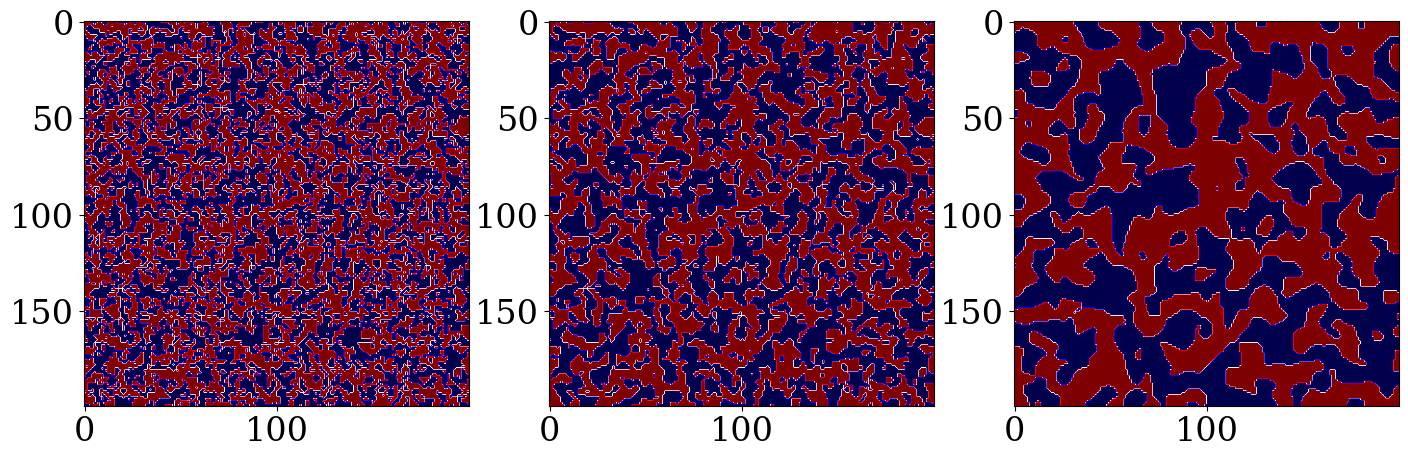

In [312]:
plt.figure(figsize=(17,5))
plt.subplot(131)
plt.imshow((P2_array[:,:,30]-np.mean(P2_array[:,:,30]))>0,cmap='seismic')
plt.subplot(132)
plt.imshow((P2_array[:,:,100]-np.mean(P2_array[:,:,100]))>0,cmap='seismic')
plt.subplot(133)
plt.imshow((P2_array[:,:,499]-np.mean(P2_array[:,:,499]))>0,cmap='seismic')

In [325]:
W2 = np.zeros(Nsteps)

for i in range(Nsteps):
    
    meanP = np.mean(P2_array[:,:,i])
    W2[i] = np.sqrt(np.mean((P2_array[:,:,i]-meanP)**2))

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


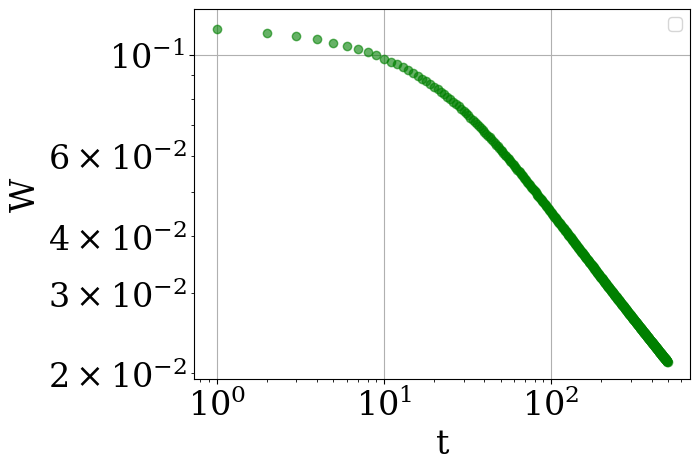

In [280]:
plt.plot(np.arange(0,500),W2[:500],'go',alpha=0.6)
#plt.plot(np.arange(300,1000),0.56*np.arange(300,1000)**(7/100),'b--',label = "$\\beta$ = 7/100")
#plt.plot(np.arange(10,1000),0.3*np.arange(10,1000)**(-2/5),'r--',label = "$\\beta$ = -2/5")
plt.yscale('log')
plt.xscale('log')
#plt.xlim(200,1000)
plt.xlabel("$\mathregular{t}$",fontsize = 24,fontdict= {'family':'serif'})
plt.ylabel("$\mathregular{W}$",fontsize = 24,fontdict= {'family':'serif'})
plt.legend(fontsize=13,prop=font,loc = "best")
plt.grid()

In [326]:
LargestC2 = np.zeros(Nsteps)
NC2 = np.zeros(Nsteps)

for i in range(30,Nsteps):
    
    meanP = np.mean(P2_array[:,:,i])
    P1 = (P2_array[:,:,i]-meanP)
    Pdev = P1>0.0
    dil_Pdev = (ndimage.binary_erosion(Pdev))
    list_L = clustersizes(dil_Pdev)
    LargestC2[i] = (np.max(list_L))
    NC2[i] = len(list_L)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


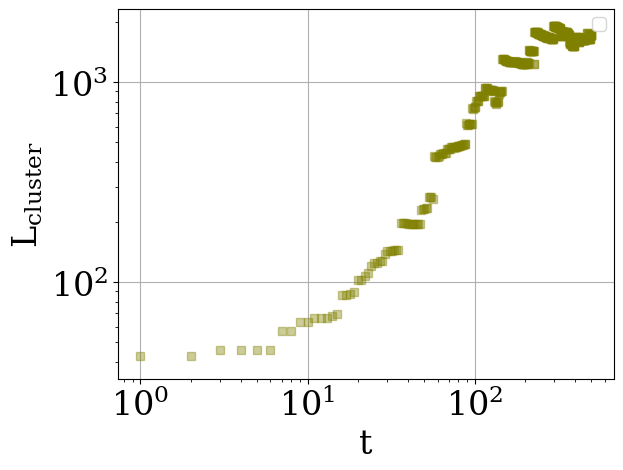

In [290]:
plt.plot(LargestC2,'s',color = 'olive',alpha=0.4)
plt.yscale('log')
plt.xscale('log')
#plt.ylim(100,1100)
#plt.plot(np.arange(20,200),6*np.arange(20,200)**(1),'r--',label = "z = 3")
#plt.plot(np.arange(10,50),1450*np.arange(10,50)**(-3/10),'g--',label = "z = -3/10")
#plt.plot(np.arange(80,500),1620*np.arange(80,500)**(-20/100),'b--',label = "z = -1/5")
plt.xlabel("$\mathregular{t}$",fontsize = 24,fontdict= {'family':'serif'})
plt.ylabel("$\mathregular{L}_\mathregular{cluster}$",fontsize = 24,fontdict= {'family':'serif'})
plt.legend(fontsize=13,prop=font,loc = "best")
plt.grid()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


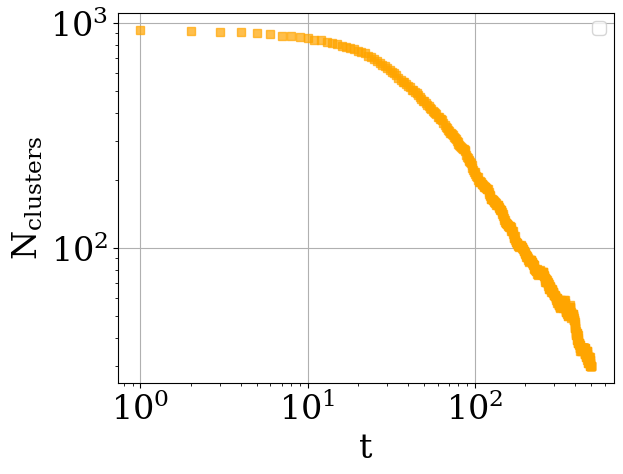

In [289]:
plt.plot(NC2,'s',color='orange',alpha=0.7)
plt.yscale('log')
plt.xscale('log')
#plt.plot(np.arange(10,1000),27000*np.arange(10,1000)**(-1),'b--',label = "$\\lambda$ = -6/5")
plt.xlabel("$\mathregular{t}$",fontsize = 24,fontdict= {'family':'serif'})
plt.ylabel("$\mathregular{N}_\mathregular{clusters}$",fontsize = 24,fontdict= {'family':'serif'})
plt.legend(fontsize=13,prop=font,loc = "best")
plt.grid()

In [327]:
with open("KPZExponentsFit.txt",'a') as text:
    logW = np.log(W2[30:500])
    logX = np.log(np.arange(30,500))*(1)
    reg4 = LinearRegression().fit(logX.reshape(-1, 1),logW)
    text.write("$\mathregular{\\beta=} $" + str(reg4.coef_.round(2)[0])+", $\mathregular{W_0} = $" + str(np.exp(reg4.intercept_).round(3))+"\n")
    logC = np.log(LargestC2[30:300])
    logX = np.log(np.arange(30,300))*(1)
    reg4 = LinearRegression().fit(logX.reshape(-1, 1),logC)
    text.write("$\mathregular{z=} $" + str(reg4.coef_.round(2)[0])+", $\mathregular{L_0} = $" + str(np.exp(reg4.intercept_).round(3))+"\n")
    logN = np.log(NC2[30:300])
    logX = np.log(np.arange(30,300))*(1)
    reg4 = LinearRegression().fit(logX.reshape(-1, 1),logN)
    text.write("$\mathregular{\\lamdba=} $" + str(reg4.coef_.round(2)[0])+", $\mathregular{N_0} = $" + str(np.exp(reg4.intercept_).round(3))+"\n")
    text.write("\n")